# Calculate Job Power Schedules with LP

This program is designed to take in n number of distinct power scheduling jobs and determine their ideal ordering in to minimize the peak amount of power demand above a provided resource curve. 
\
This is a relaxed ILP problem. Therefore, it uses typical LP to solve the problem in polynomial time and then probability to estimate the optimal schedule of jobs.


In [ ]:
import cplex
import random
import json
import matplotlib.pyplot as plt
import numpy as np

# Generate Jobs and Other Variables
We need to generate the jobs, decision variables and extract other information that will be necessary for the LP to run

**Jobs** -> The power requiring tasks upon which this problem is built. Each job will have the following format:
\
\
&emsp;&emsp;**release** -> The minimum time that a specific job can begin by. A job can begin no earlier than the release time \
&emsp;&emsp;**deadline** -> The maximum time that a job must complete by. A job can end no later than the deadline time \
&emsp;&emsp;**duration** -> The length (in minutes) that a task will need to complete \
&emsp;&emsp;**height** -> The amount of consistent power that a task will require

In [ ]:
# This is The list of job objects that will be scheduled
# They each have a release, deadline, duration and height
path = '../../Input_Data/job_data.json'
with open(path, 'r') as file:
    data = json.load(file)

start_time = 0
end_time = 1400
max_length = 700
batch_size = 1000

# Randomly shuffle the jobs so that there is variation between trials
jobs_array = data['jobs']
random.shuffle(jobs_array)

jobs = []

# Iterate through the job objects and create an array of objects that fall within the specified time window
i = 0
curr_index = 0
while (i < batch_size):
    aj = jobs_array[curr_index]['release']
    dj = jobs_array[curr_index]['deadline']
    lj = jobs_array[curr_index]['length']

    # Check if the specific job lies within the correct window
    # The funky syntax is used to put the job id at the very front of the dictionary
    if aj >= start_time and dj <= end_time and lj <= max_length:
        job_id = {"job_id" : i}
        job_object = {**job_id, **jobs_array[curr_index]}
        jobs.append(job_object)
        
        i += 1
    
    curr_index += 1

print(len(jobs), len(jobs_array))

# # Write these specific jobs to a file so that the ILP can access them
# with open("jobs.json", "w") as file:
#     json.dump(jobs, file)


# path = 'jobs.json'
# with open(path, 'r') as file:
#     data = json.load(file)

# jobs = data['jobs']

# start_time = 400
# end_time = 1400

1000 88200


**Intervals** -> The overall intervals list is composed of exactly J sublists, where J = the number of total jobs
\
\
&emsp;&emsp;- Each entry within a sublist is a two integer tuple representing a possible start and end execution time for the corresponding job \
&emsp;&emsp;- For example, the entry (3, 6) in the intervals[0] means that the first job can possibly execute between time steps 3 and 6 (where the start \
&emsp;&emsp;time is inclusive and the end time is exclusive)

In [112]:
intervals = [[] for _ in range(len(jobs))]
for i, job in enumerate(jobs):
    # Extract the necessary information from the job object
    release = job['release'] - start_time
    deadline = job['deadline'] - start_time
    duration = job['length']
    num = release

    # Add the execution intervals to the sublist
    while (num + duration <= deadline):
        intervals[i].append((num, num + duration))
        num += 1

**Time Steps** -> This is simply the number of time steps in the time period between the specified start and end time. Each time step equates to exactly one minute

In [113]:
# Specify the number of time steps 
num_time_steps = end_time - start_time

**Resources** -> This is a list that keeps track of the amount of available resources at each time step
\
\
&emsp;&emsp;- The resource curve information will be gathered from the Data/ folder.

In [114]:
# Instantiate the resource curve

path = '../../Input_Data/solar_data.json'
with open(path, 'r') as file:
    data = json.load(file)

wind_energy = data['series'][1]['data']
solar_energy = data['series'][2]['data']
hydro_energy = data['series'][3]['data']

# Have 165 hours and you want minute by minute resolution. Therefore the total length of this list needs to be 165 * 60 in length
# The first 60 values of the list need to equal 0, the next need to equal 1. Therefore, i // 60
wind_energy_7_days = [0 for _ in range(165 * 60)]
for i in range(len(wind_energy_7_days)):
    wind_energy_7_days[i] = wind_energy[ i // 60 ]['value']

solar_energy_7_days = [0 for _ in range(165 * 60)]
for i in range(len(solar_energy_7_days)):
    solar_energy_7_days[i] = solar_energy[ i // 60 ]['value']

hydro_energy_7_days = [0 for _ in range(165 * 60)]
for i in range(len(hydro_energy_7_days)):
    hydro_energy_7_days[i] = hydro_energy[ i // 60 ]['value']


total = []
for i in range(165 * 60):
    total_sum = wind_energy_7_days[i] + solar_energy_7_days[i] + hydro_energy_7_days[i]
    total.append(total_sum)

day = 3
resources = total[(24 * day) + start_time : (24 * day) + end_time]


**Height** -> This is a list containing exactly J entries, where each entry contains that height of the corresponding job. The height of the jobs will be dependent on a scale factor. For now, we will scale the jobs based on the relationship between the max value of the resource curve and the max value of the naive job schedule
\
\
The naive job schedule, generated below, scehdules each job exactly at their respective start times. From this, we generate the scale factor. We want the peak to be 75% above the resource curve (for now)
\
\
&emsp;&emsp;- The height is another word for the amount of the given resource that a job will consistently require while it is running.
\
&emsp;&emsp;- Therefore, height[0] = 400 means that the first job requires 400 unites of the given resource
\


In [115]:
bad_heights = [0 for _ in range(num_time_steps)]
for job in jobs:
    aj = job['release'] - start_time
    hj = job['height']
    lj = job['length']

    for i in range(aj, aj + lj):
        bad_heights[i] += hj


scale_factor = (max(resources) * 2) / max(bad_heights)

In [116]:
# Iterate through the jobs and add their corresponding heights
height = [job['height'] * scale_factor for job in jobs]

# Decision Variables
**Decision variables** -> A key component of the ILP. They represent each distint execution interval for each job. They can assume any value in [0, 1]. 
\
\
&emsp;&emsp;- This code creates a list of decision variables with the form {'name': x_i_j, value: ?} where each name is a distinct time interval for a distinct job. 
\
&emsp;&emsp;- Specifically, this is saying that decision variable x_i_j is the ith possible interval for job j where the value is the actual interval of time steps. 
\
&emsp;&emsp;- This is stored here so we don't have to repeatedly query the intervals list
\
\
**Objective variable** -> Instantiate the variable that will be minimized during the problem's execution

In [117]:
decision_variables = []
for j, interval_set in enumerate(intervals):
    for i, interval in enumerate(interval_set):
        # Add the decision variable and it's corresponding interval to the list
        decision_variables.append({'name' : f'x_{i}_{j}', 'value': interval})

# This is the name of the objective variable that we will minimize
objective_variable = 'd'

# Create the LP
Create an LP problem with CPLEX. We have to specify the decision variables for the problem. And then we must specify their respective upper bounds and lower bounds.
\
\
Finally we have to set up the objective function. In this case, the objective function will be to minimize a variable named 'd'. Where d is initially set to the highest point the job schedule curve could possibly be, which is the total sum of the 'heights' list.

In [118]:
# Create the cplex problem
problem = cplex.Cplex()
problem.set_problem_type(cplex.Cplex.problem_type.LP)
problem.set_results_stream(None)

# Maximize objective
problem.objective.set_sense(problem.objective.sense.minimize)

# This retrieves the names of all of the decision variables 
names = [variable['name'] for variable in decision_variables] + [objective_variable]

# these are the other parameters needed to form the basis of the linear programming problem
obj = [0 for _ in range(len(decision_variables))] + [1] # only minimizing d
lb = [0 for _ in range(len(decision_variables))] + [0]
ub = [1 for _ in range(len(decision_variables)) ] + [sum(height)]


# Establish the problem
types = [problem.variables.type.continuous] * (len(decision_variables)) + [problem.variables.type.continuous]
problem.variables.add(obj=obj, lb=lb, ub=ub, types=types, names=names)

range(0, 79016)

# Constraints
This will generate the first set of constraints

This for loop adds the constraints that make it so that a job can run during only one interval. So for each job, aggregate all of the decision variables that correspond to each possible execution interval for that job. Then specify that they all of those decision variables can only add up to one  

In [119]:
curr_index = 0
for interval in intervals:
    # Aggregate all the decision variables that belong to one job
    variables = decision_variables[curr_index : curr_index + (len(interval))]
    variables = [v['name'] for v in variables]
    curr_index += len(interval)
    
    # The coefficient of each decision variable is one
    constraints = [1 for _ in range(len(variables))]

    # This is saying that the sum of each of the decision variabels can only equal one
    problem.linear_constraints.add(
        lin_expr=[ [ variables, constraints ] ],
        senses=['E'],
        rhs=[1]
    )

This generates the second set of constraints 
\
\
It aggregates all of the desicion variables that correspond to intervals that could possibly be running during that time step. /
It then aggregates the heights corresponding to the jobs that each decision variable represents. 
It multiplies those heights by the decision variables. However, the constrain ensures that the total sum is less than the max height d

In [120]:
for i in range(num_time_steps):
    use_variables = []
    use_height = []

    for variable in decision_variables:
        
        # Check the interval times of the corresponding variable
        # Then check if the current timestep falls within that interval
        job_interval_start, job_interval_end = variable['value'][0], variable['value'][1]

        if job_interval_start <= i < job_interval_end:
            job_id = int(variable['name'].split('_')[-1])

            use_height.append(height[job_id])
            use_variables.append(variable['name'])

    # Add d to the decision variables 
    use_variables.append('d')
    use_height.append(-1)

    # Add the linear constraint to the problem
    problem.linear_constraints.add(
        lin_expr=[ [ use_variables, use_height ] ],
        senses=['L'],
        rhs=[resources[i]]
    )


# Solve the LP problem

Use CPLEX to solve the formulated LP problem and then use post processing to extract the intervals each job will run in.

In [121]:
problem.solve()
solution = problem.solution

# Choose the job intervals
Each decision variable for a specific job will have a value between 0-1. However, we need to choose exactly one interval for a specific job to run in.
\
\
Therefore, we use the values of the decision variables as a probability that that specific interval will run. This means that if a decision variable has a higher value, it's corresponding interval has a higher likelihood of being chosen for the job. 

In [122]:
# Loop through each of the jobs and generate a random number
# Choose a decision variable based on the probability of the current value of the decision variables
# Add that chosen variable to a final list so that the overall objective value can be ascertained
final_intervals = []
final_heights = [0 for _ in range(num_time_steps)]

curr_index = 0
# Loop through each job
for job_id in range(len(intervals)):
    # Generate a random number for the job to be used to select a specific interval
    random_num = random.uniform(0, 1)
    probability = 0

    # Loop through each interval in the job and get the value corresponding to each interval (decision variable)
    # Add the decision variable to the final interval list based on the random number 
    for i, interval in enumerate(intervals[job_id]):
        decision_variable = decision_variables[curr_index]
        decision_value = solution.get_values(decision_variable['name'])
        probability += decision_value

        if random_num <= probability and len(final_intervals) <= job_id:
            final_intervals.append(decision_variable)
        
        curr_index += 1

# Generate the height of all of the jobs over the course of all of the time steps
# Do this by iterating through all of the selected job intervals in final_intervals and add their height values 
# to the final_heights arrays. From this we can determine the objective value of d
# simply take the maximum from this height list
for job_id, job in enumerate(final_intervals):
    job_start = job['value'][0]
    job_end = job['value'][1]
    job_height = height[job_id]

    for i in range(job_start, job_end):
        final_heights[i] += job_height

We calculate the objective value to be the greatest difference between the job scheduling curve and the resource curve.

In [123]:
objective_value = 0
for i, height in enumerate(final_heights):
    if height - resources[i] > objective_value:
        objective_value = height - resources[i]

print("Inexact Objective Value:", objective_value)

naive_objective_value = 0
for i, height in enumerate(bad_heights):
    if (height * scale_factor) - resources[i] > naive_objective_value:
        naive_objective_value = (height * scale_factor) - resources[i]

print("Inexact Objective Value:", naive_objective_value)


Inexact Objective Value: 6058.783478236057
Inexact Objective Value: 11057.0


# Plot the Jobs

Use Matplotlib to plot the jobs on a curve

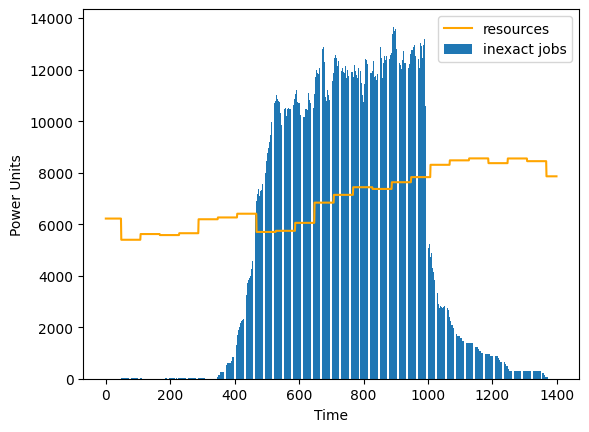

In [ ]:
job_graph_xvalues = np.array([i for i in range(start_time, end_time)])

job_graph_yvalues = np.array(final_heights)
resources_graph_yvalues = np.array(resources)

plt.bar(job_graph_xvalues, job_graph_yvalues, label='inexact jobs')
plt.plot(job_graph_xvalues, resources_graph_yvalues, label='resources', color='orange')

plt.xlabel("Time")
plt.ylabel("Power Units")
plt.legend()

plt.show()

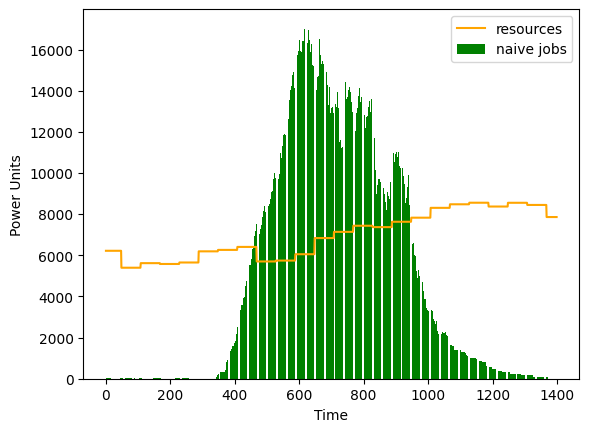

In [125]:
resources_graph_yvalues = np.array(resources)
bad_job_graph_yvalues = np.array([height * scale_factor for height in bad_heights])

plt.bar(job_graph_xvalues, bad_job_graph_yvalues, label='naive jobs', color='green')
plt.plot(job_graph_xvalues, resources_graph_yvalues, label='resources', color='orange')

plt.xlabel("Time")
plt.ylabel("Power Units")
plt.legend()

plt.show()

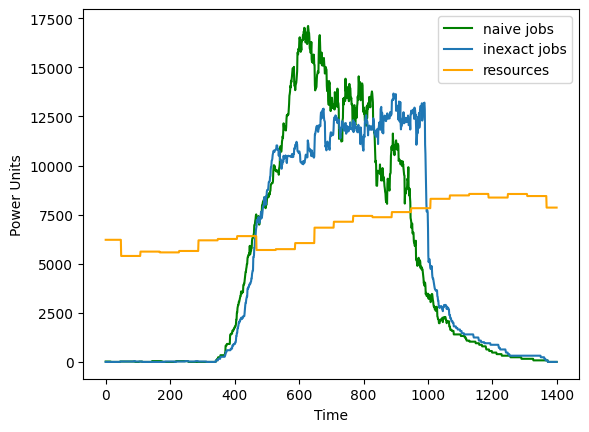

In [126]:
plt.plot(job_graph_xvalues, bad_job_graph_yvalues, label='naive jobs', color='green')
plt.plot(job_graph_xvalues, job_graph_yvalues, label='inexact jobs')
plt.plot(job_graph_xvalues, resources_graph_yvalues, label='resources', color='orange')

plt.xlabel("Time")
plt.ylabel("Power Units")
plt.legend()

plt.show()